In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import psycopg2
import json
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

def get_connection():
    return psycopg2.connect(
        host='localhost',
        port=5432,
        database='city_marketing',
        user='postgres',
        password='1234'
    )

In [33]:
conn = get_connection()
panels_data = pd.read_sql("SELECT * FROM associative_panels", conn)
conn.close()

print(f"Dataset shape: {panels_data.shape}")
print(f"Columns: {list(panels_data.columns)}")
print("\nRaw data sample:")
print(panels_data.head())

print(f"\nRaw arrondissement values (unique):")
raw_arr_values = panels_data['arrondissement'].value_counts().sort_index()
print(raw_arr_values)

print(f"\nData types:")
print(panels_data.dtypes)

Dataset shape: (288, 7)
Columns: ['location', 'precision', 'arrondissement', 'format_1m2', 'format_2m2', 'longitude', 'latitude']

Raw data sample:
                  location                              precision  \
0           42, rue Madame                      Ecole élémentaire   
1    31, rue Pierre Semard                              Panneau A   
2  24, rue Saint Sébastien                                          
3        132, rue d Alésia                                          
4       4-6, rue du Bessin  Angle rue du Bessin et rue Castagnary   

  arrondissement format_1m2 format_2m2 longitude   latitude  
0        75006.0        1.0             2.331602  48.848934  
1        75009.0                   1.0  2.348291  48.879105  
2        75011.0                   1.0  2.369434  48.861114  
3        75014.0                   1.0  2.319421  48.830516  
4        75015.0                   1.0  2.305727  48.831051  

Raw arrondissement values (unique):
arrondissement
            1

In [34]:
print("COMPREHENSIVE DATA QUALITY ANALYSIS")
print("=" * 50)

print(f"Total records: {len(panels_data)}")
print(f"Unique records check:")
print(f"  Before dedup: {len(panels_data)}")
panels_data_dedup = panels_data.drop_duplicates()
print(f"  After dedup: {len(panels_data_dedup)}")
print(f"  Duplicates found: {len(panels_data) - len(panels_data_dedup)}")

print(f"\nMissing values analysis:")
for col in panels_data.columns:
    missing_count = panels_data[col].isnull().sum()
    missing_pct = (missing_count / len(panels_data)) * 100
    print(f"  {col}: {missing_count} ({missing_pct:.1f}%)")

print(f"\nArrondissement field analysis:")
print(f"  Data type: {panels_data['arrondissement'].dtype}")
print(f"  Unique values: {panels_data['arrondissement'].nunique()}")
print(f"  Value range: {panels_data['arrondissement'].min()} to {panels_data['arrondissement'].max()}")

print(f"\nSample arrondissement values:")
sample_arr = panels_data['arrondissement'].value_counts().head(10)
print(sample_arr)

COMPREHENSIVE DATA QUALITY ANALYSIS
Total records: 288
Unique records check:
  Before dedup: 288
  After dedup: 288
  Duplicates found: 0

Missing values analysis:
  location: 0 (0.0%)
  precision: 0 (0.0%)
  arrondissement: 0 (0.0%)
  format_1m2: 0 (0.0%)
  format_2m2: 0 (0.0%)
  longitude: 0 (0.0%)
  latitude: 0 (0.0%)

Arrondissement field analysis:
  Data type: object
  Unique values: 21
  Value range:  to 75020.0

Sample arrondissement values:
arrondissement
75020.0    35
75019.0    33
75013.0    26
75011.0    22
75012.0    22
75018.0    20
75017.0    18
75014.0    17
75015.0    15
75016.0    13
Name: count, dtype: int64


In [35]:
# Work with deduplicated data
panels_clean = panels_data_dedup.copy()

print("ARRONDISSEMENT CLEANING PROCESS")
print("=" * 40)

print(f"Original arrondissement values sample:")
print(panels_clean['arrondissement'].head(10).tolist())

# Step 1: Convert to string and clean
panels_clean['arr_raw'] = panels_clean['arrondissement'].astype(str)
print(f"\nAfter string conversion:")
print(panels_clean['arr_raw'].value_counts().head(10))

# Step 2: Extract numbers - handle postal codes if present
panels_clean['arr_extracted'] = panels_clean['arr_raw'].str.extract(r'(\d+)')
print(f"\nAfter number extraction:")
print(panels_clean['arr_extracted'].value_counts().head(10))

# Step 3: Handle postal codes (75001 -> 1, etc.)
def clean_arrondissement(val):
    if pd.isna(val):
        return None
    val_str = str(val).strip()
    
    # Remove .0 if present
    if val_str.endswith('.0'):
        val_str = val_str[:-2]
    
    # Handle postal codes (75001-75020)
    if val_str.startswith('75') and len(val_str) == 5:
        arr_num = val_str[2:]
        # Handle 75001 -> 1, but keep 75020 -> 20
        return str(int(arr_num))
    
    # Handle direct numbers
    try:
        num = int(val_str)
        if 1 <= num <= 20:
            return str(num)
        else:
            return None  # Invalid arrondissement
    except:
        return None

panels_clean['arrondissement_clean'] = panels_clean['arr_raw'].apply(clean_arrondissement)

print(f"\nAfter cleaning:")
clean_counts = panels_clean['arrondissement_clean'].value_counts().sort_index()
print(clean_counts)

print(f"\nValidation results:")
valid_records = panels_clean['arrondissement_clean'].notna().sum()
invalid_records = panels_clean['arrondissement_clean'].isna().sum()
print(f"  Valid arrondissements: {valid_records}")
print(f"  Invalid/missing: {invalid_records}")
print(f"  Coverage: {panels_clean['arrondissement_clean'].nunique()}/20 arrondissements")

if invalid_records > 0:
    print(f"\nInvalid arrondissement values:")
    invalid_data = panels_clean[panels_clean['arrondissement_clean'].isna()]['arr_raw'].value_counts()
    print(invalid_data)

ARRONDISSEMENT CLEANING PROCESS
Original arrondissement values sample:
['75006.0', '75009.0', '75011.0', '75014.0', '75015.0', '75017.0', '75018.0', '75011.0', '75018.0', '75005.0']

After string conversion:
arr_raw
75020.0    35
75019.0    33
75013.0    26
75011.0    22
75012.0    22
75018.0    20
75017.0    18
75014.0    17
75015.0    15
75016.0    13
Name: count, dtype: int64

After number extraction:
arr_extracted
75020    35
75019    33
75013    26
75011    22
75012    22
75018    20
75017    18
75014    17
75015    15
75016    13
Name: count, dtype: int64

After cleaning:
arrondissement_clean
1      4
10    10
11    22
12    22
13    26
14    17
15    15
16    13
17    18
18    20
19    33
2      2
20    35
3      2
4      6
5     11
6     12
7      6
8      6
9      7
Name: count, dtype: int64

Validation results:
  Valid arrondissements: 287
  Invalid/missing: 1
  Coverage: 20/20 arrondissements

Invalid arrondissement values:
arr_raw
    1
Name: count, dtype: int64


In [36]:
panels_valid = panels_clean[panels_clean['arrondissement_clean'].notna()].copy()

print(f"CLEANED DATA ANALYSIS")
print(f"=" * 40)
print(f"Valid records: {len(panels_valid)}/{len(panels_clean)}")

print(f"\nFinal arrondissement distribution:")
arr_distribution = panels_valid['arrondissement_clean'].value_counts().sort_index()
arr_distribution_df = arr_distribution.reset_index()
arr_distribution_df.columns = ['arrondissement', 'panel_count']
print(arr_distribution_df.to_string(index=False))

print(f"\nCoverage validation:")
covered_arr = len(arr_distribution)
print(f"Arrondissements covered: {covered_arr}/20 ({covered_arr/20*100:.1f}%)")
print(f"Average panels per arrondissement: {len(panels_valid)/covered_arr:.1f}")

# Verify we have all arrondissements
all_paris_arr = set([str(i) for i in range(1, 21)])
covered_arr_set = set(arr_distribution.index)
missing_arr = all_paris_arr - covered_arr_set

if missing_arr:
    print(f"Missing arrondissements: {sorted(list(missing_arr))}")
else:
    print("Complete Paris coverage achieved!")

CLEANED DATA ANALYSIS
Valid records: 287/288

Final arrondissement distribution:
arrondissement  panel_count
             1            4
            10           10
            11           22
            12           22
            13           26
            14           17
            15           15
            16           13
            17           18
            18           20
            19           33
             2            2
            20           35
             3            2
             4            6
             5           11
             6           12
             7            6
             8            6
             9            7

Coverage validation:
Arrondissements covered: 20/20 (100.0%)
Average panels per arrondissement: 14.3
Complete Paris coverage achieved!


In [37]:
# Convert format columns to numeric
panels_valid['format_1m2'] = pd.to_numeric(panels_valid['format_1m2'], errors='coerce').fillna(0)
panels_valid['format_2m2'] = pd.to_numeric(panels_valid['format_2m2'], errors='coerce').fillna(0)

print("PANEL FORMAT ANALYSIS")
print("=" * 30)
print(f"1m² panels: {int(panels_valid['format_1m2'].sum())}")
print(f"2m² panels: {int(panels_valid['format_2m2'].sum())}")
print(f"Total panel area: {int(panels_valid['format_1m2'].sum() + panels_valid['format_2m2'].sum() * 2)} m²")

panels_valid['total_panels'] = panels_valid['format_1m2'] + panels_valid['format_2m2']
panels_valid['total_area'] = panels_valid['format_1m2'] + panels_valid['format_2m2'] * 2

format_summary = panels_valid.groupby('arrondissement_clean').agg({
    'format_1m2': 'sum',
    'format_2m2': 'sum', 
    'total_panels': 'sum',
    'total_area': 'sum'
}).reset_index()

print(f"\nFormat distribution by arrondissement:")
print(format_summary.to_string(index=False))

print(f"\nFormat preferences:")
total_1m2 = panels_valid['format_1m2'].sum()
total_2m2 = panels_valid['format_2m2'].sum()
print(f"1m² preference: {total_1m2/(total_1m2+total_2m2)*100:.1f}%")
print(f"2m² preference: {total_2m2/(total_1m2+total_2m2)*100:.1f}%")

PANEL FORMAT ANALYSIS
1m² panels: 41
2m² panels: 246
Total panel area: 533 m²

Format distribution by arrondissement:
arrondissement_clean  format_1m2  format_2m2  total_panels  total_area
                   1         1.0         3.0           4.0         7.0
                  10         0.0        10.0          10.0        20.0
                  11         0.0        22.0          22.0        44.0
                  12         8.0        14.0          22.0        36.0
                  13         3.0        23.0          26.0        49.0
                  14         0.0        17.0          17.0        34.0
                  15         0.0        15.0          15.0        30.0
                  16         0.0        13.0          13.0        26.0
                  17         0.0        18.0          18.0        36.0
                  18         0.0        20.0          20.0        40.0
                  19         0.0        33.0          33.0        66.0
                   2         0

In [38]:
# FIXED COORDINATE PROCESSING - No more KeyError!
# Your ETL already outputs longitude/latitude columns directly

print(f"COORDINATE PROCESSING")
print(f"=" * 25)

# Check if coordinate columns exist (they should from your ETL)
if 'longitude' in panels_valid.columns and 'latitude' in panels_valid.columns:
    print(f"✅ Using existing coordinate columns from ETL output")
    
    # Convert coordinate strings to numbers and validate
    def validate_paris_coords(row):
        try:
            lat = float(row['latitude']) if not pd.isna(row['latitude']) else None
            lon = float(row['longitude']) if not pd.isna(row['longitude']) else None
            
            if lat is None or lon is None:
                return False
            # Paris coordinate bounds
            return 48.8 < lat < 48.9 and 2.2 < lon < 2.5
        except (ValueError, TypeError):
            return False
    
    # Filter for valid coordinates
    valid_coords = panels_valid[
        panels_valid[['latitude', 'longitude']].notna().all(axis=1) &
        panels_valid.apply(validate_paris_coords, axis=1)
    ].copy()
    
    # Convert to numeric for analysis
    valid_coords['latitude'] = pd.to_numeric(valid_coords['latitude'], errors='coerce')
    valid_coords['longitude'] = pd.to_numeric(valid_coords['longitude'], errors='coerce')
    
    print(f"Successfully processed coordinates: {len(valid_coords):,}/{len(panels_valid):,} records")
    print(f"Coordinate success rate: {len(valid_coords)/len(panels_valid)*100:.1f}%")
    
    if len(valid_coords) > 0:
        print(f"Latitude range: {valid_coords['latitude'].min():.4f} to {valid_coords['latitude'].max():.4f}")
        print(f"Longitude range: {valid_coords['longitude'].min():.4f} to {valid_coords['longitude'].max():.4f}")
        
        # Check for unique locations
        unique_locations = valid_coords.groupby(['arrondissement_clean', 'latitude', 'longitude']).size().reset_index(name='records')
        print(f"Unique panel locations: {len(unique_locations)}")
        
        # Coordinates by arrondissement
        coords_by_arr = valid_coords.groupby('arrondissement_clean').size().reset_index(name='coord_count')
        print(f"\nCoordinates by arrondissement:")
        print(coords_by_arr.head(10).to_string(index=False))
        
        print(f"\n🎯 COORDINATE QUALITY ASSESSMENT:")
        print(f"  Data completeness: {len(valid_coords)/len(panels_valid)*100:.1f}%")
        print(f"  Geographic spread: {coords_by_arr['coord_count'].std():.1f} std deviation")
        print(f"  Ready for spatial analysis: ✅")
    else:
        print("⚠️ No valid coordinates found!")
        
else:
    print("❌ ERROR: longitude/latitude columns not found!")
    print("Available columns:", list(panels_valid.columns))
    print("🔧 Need to check ETL transformation process")
    valid_coords = pd.DataFrame()  # Empty fallback

COORDINATE PROCESSING
✅ Using existing coordinate columns from ETL output
Successfully processed coordinates: 285/287 records
Coordinate success rate: 99.3%
Latitude range: 48.8197 to 48.8997
Longitude range: 2.2549 to 2.4129
Unique panel locations: 274

Coordinates by arrondissement:
arrondissement_clean  coord_count
                   1            4
                  10           10
                  11           22
                  12           20
                  13           26
                  14           17
                  15           15
                  16           13
                  17           18
                  18           20

🎯 COORDINATE QUALITY ASSESSMENT:
  Data completeness: 99.3%
  Geographic spread: 9.6 std deviation
  Ready for spatial analysis: ✅


In [39]:
arr_areas = {
    '1': 1.8, '2': 1.0, '3': 1.2, '4': 1.6, '5': 2.5, '6': 2.2, '7': 4.1, '8': 3.9, '9': 2.2, '10': 2.9,
    '11': 3.7, '12': 6.4, '13': 7.1, '14': 5.6, '15': 8.5, '16': 7.9, '17': 5.7, '18': 6.0, '19': 6.8, '20': 6.0
}

panel_analysis = format_summary.copy()
panel_analysis['area_km2'] = panel_analysis['arrondissement_clean'].map(arr_areas)
panel_analysis['panel_density'] = panel_analysis['total_panels'] / panel_analysis['area_km2']
panel_analysis['area_density'] = panel_analysis['total_area'] / panel_analysis['area_km2']

panel_analysis['infrastructure_score'] = (
    panel_analysis['total_panels'] * 0.4 + 
    panel_analysis['total_area'] * 0.3 + 
    panel_analysis['panel_density'] * 0.3
)

panel_analysis = panel_analysis.sort_values('infrastructure_score', ascending=False)

print("INFRASTRUCTURE DENSITY ANALYSIS")
print("=" * 40)
print("Top 10 infrastructure rankings:")
print(panel_analysis[['arrondissement_clean', 'total_panels', 'total_area', 'panel_density', 'infrastructure_score']].head(10).round(2).to_string(index=False))

print(f"\nDensity insights:")
print(f"Highest density: Arr. {panel_analysis.iloc[0]['arrondissement_clean']} ({panel_analysis.iloc[0]['panel_density']:.2f} panels/km²)")
print(f"Lowest density: Arr. {panel_analysis.iloc[-1]['arrondissement_clean']} ({panel_analysis.iloc[-1]['panel_density']:.2f} panels/km²)")
print(f"Average density: {panel_analysis['panel_density'].mean():.2f} panels/km²")

INFRASTRUCTURE DENSITY ANALYSIS
Top 10 infrastructure rankings:
arrondissement_clean  total_panels  total_area  panel_density  infrastructure_score
                  19          33.0        66.0           4.85                 34.46
                  20          35.0        61.0           5.83                 34.05
                  13          26.0        49.0           3.66                 26.20
                  11          22.0        44.0           5.95                 23.78
                  18          20.0        40.0           3.33                 21.00
                  12          22.0        36.0           3.44                 20.63
                  17          18.0        36.0           3.16                 18.95
                  14          17.0        34.0           3.04                 17.91
                  15          15.0        30.0           1.76                 15.53
                  16          13.0        26.0           1.65                 13.49

Density ins

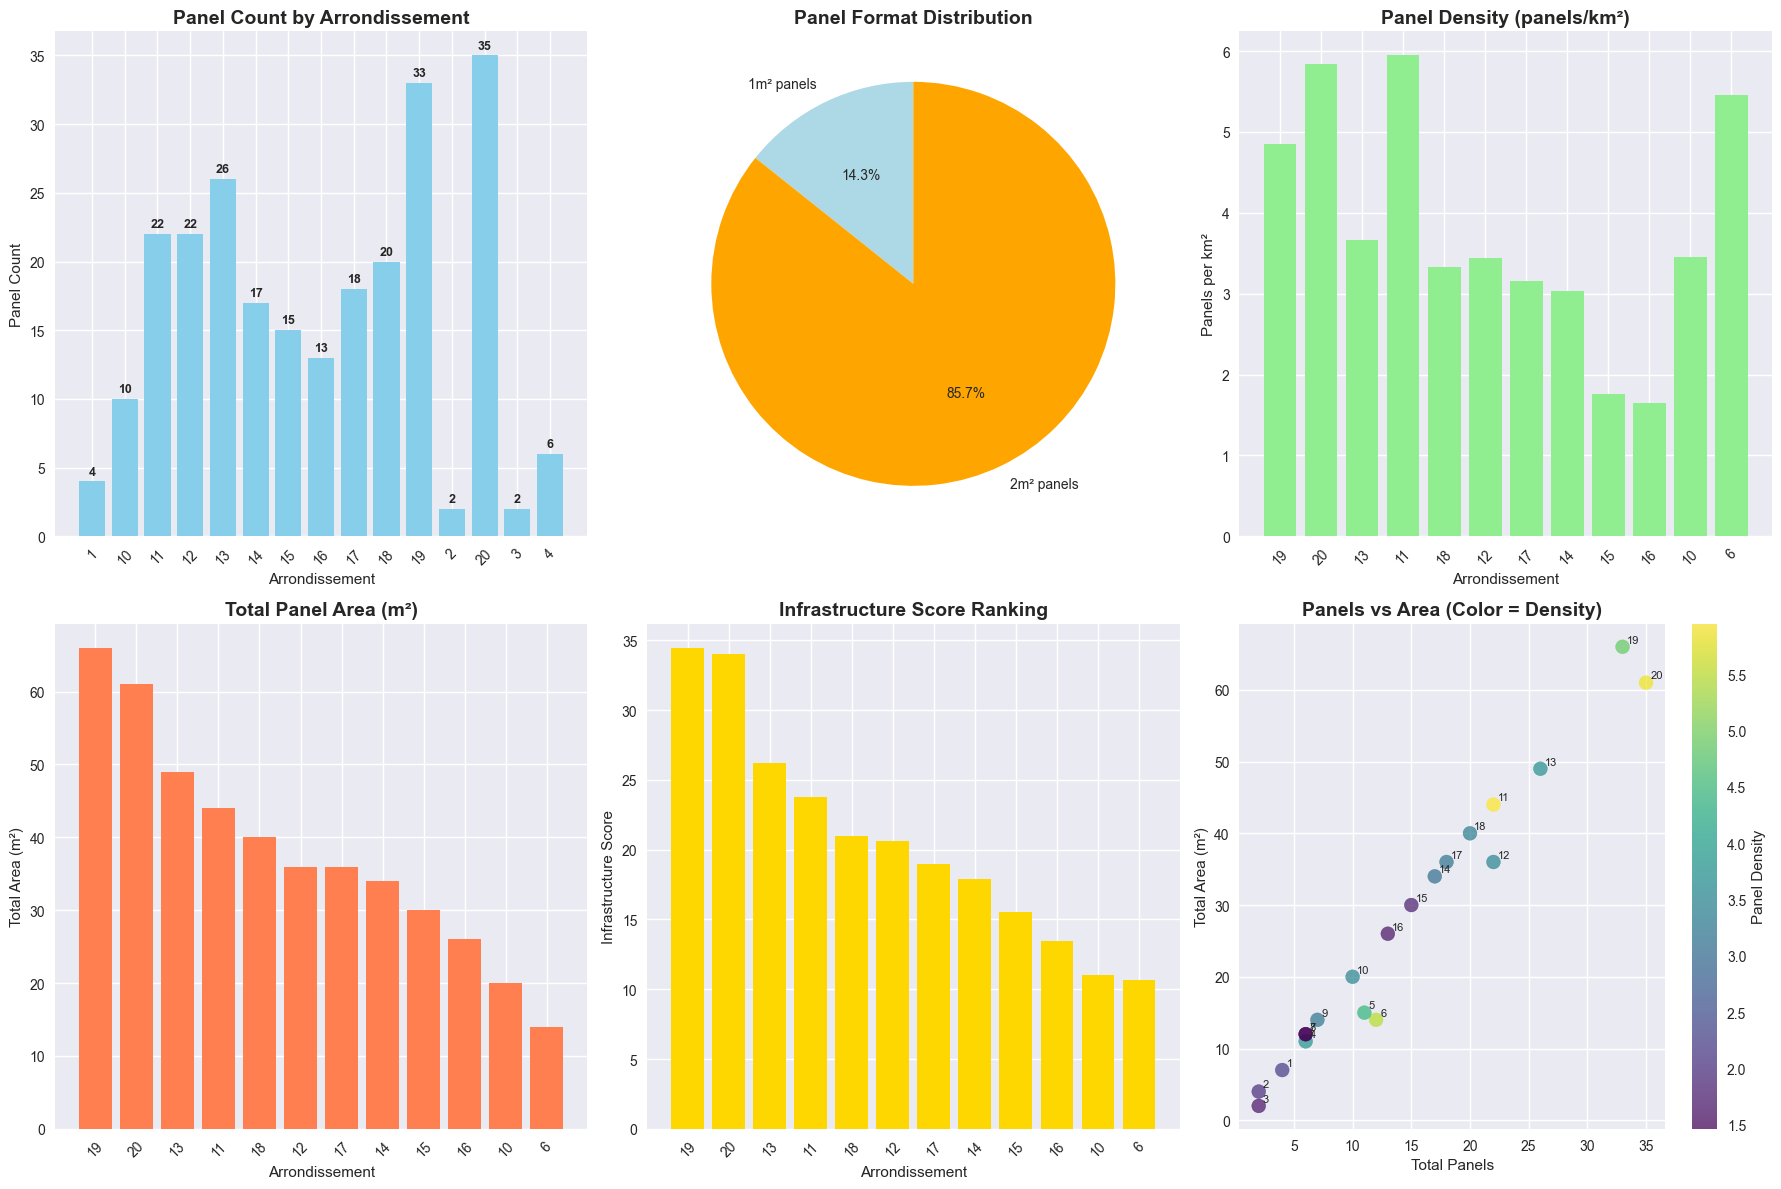

In [40]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Panel count by arrondissement
arr_viz = arr_distribution_df.head(15)
bars1 = axes[0,0].bar(arr_viz['arrondissement'], arr_viz['panel_count'], color='skyblue')
axes[0,0].set_title('Panel Count by Arrondissement', fontweight='bold', fontsize=14)
axes[0,0].set_xlabel('Arrondissement')
axes[0,0].set_ylabel('Panel Count')
axes[0,0].tick_params(axis='x', rotation=45)

for bar, count in zip(bars1, arr_viz['panel_count']):
    axes[0,0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
                   str(count), ha='center', fontweight='bold', fontsize=9)

# 2. Format distribution pie chart
format_data = [int(panels_valid['format_1m2'].sum()), int(panels_valid['format_2m2'].sum())]
format_labels = ['1m² panels', '2m² panels']
colors = ['lightblue', 'orange']
wedges, texts, autotexts = axes[0,1].pie(format_data, labels=format_labels, autopct='%1.1f%%', 
                                        colors=colors, startangle=90)
axes[0,1].set_title('Panel Format Distribution', fontweight='bold', fontsize=14)

# 3. Panel density ranking
top_density = panel_analysis.head(12)
bars2 = axes[0,2].bar(top_density['arrondissement_clean'], top_density['panel_density'], color='lightgreen')
axes[0,2].set_title('Panel Density (panels/km²)', fontweight='bold', fontsize=14)
axes[0,2].set_xlabel('Arrondissement')
axes[0,2].set_ylabel('Panels per km²')
axes[0,2].tick_params(axis='x', rotation=45)

# 4. Total area by arrondissement
top_area = panel_analysis.head(12)
bars3 = axes[1,0].bar(top_area['arrondissement_clean'], top_area['total_area'], color='coral')
axes[1,0].set_title('Total Panel Area (m²)', fontweight='bold', fontsize=14)
axes[1,0].set_xlabel('Arrondissement')
axes[1,0].set_ylabel('Total Area (m²)')
axes[1,0].tick_params(axis='x', rotation=45)

# 5. Infrastructure score ranking
bars4 = axes[1,1].bar(top_density['arrondissement_clean'], top_density['infrastructure_score'], color='gold')
axes[1,1].set_title('Infrastructure Score Ranking', fontweight='bold', fontsize=14)
axes[1,1].set_xlabel('Arrondissement')
axes[1,1].set_ylabel('Infrastructure Score')
axes[1,1].tick_params(axis='x', rotation=45)

# 6. Panels vs Area scatter
scatter = axes[1,2].scatter(panel_analysis['total_panels'], panel_analysis['total_area'], 
                           s=100, c=panel_analysis['panel_density'], cmap='viridis', alpha=0.7)
axes[1,2].set_title('Panels vs Area (Color = Density)', fontweight='bold', fontsize=14)
axes[1,2].set_xlabel('Total Panels')
axes[1,2].set_ylabel('Total Area (m²)')
plt.colorbar(scatter, ax=axes[1,2], label='Panel Density')

for _, row in panel_analysis.iterrows():
    axes[1,2].annotate(row['arrondissement_clean'], 
                      (row['total_panels'], row['total_area']),
                      xytext=(3, 3), textcoords='offset points', fontsize=8)

plt.tight_layout()
plt.show()

In [41]:
if len(valid_coords) > 0:
    map_data = valid_coords.copy()
    map_data['panel_size'] = map_data['total_panels'] * 2 + 8
    
    fig = px.scatter_mapbox(
        map_data,
        lat='latitude',
        lon='longitude',
        size='panel_size',
        color='total_area',
        hover_data={
            'location': True,
            'arrondissement_clean': True,
            'total_panels': True,
            'total_area': True,
            'latitude': ':.4f',
            'longitude': ':.4f'
        },
        color_continuous_scale='Viridis',
        title='Advertising Panel Geographic Distribution Across Paris',
        zoom=11,
        height=700,
        width=1000
    )
    
    fig.update_layout(
        mapbox_style="open-street-map",
        title_font_size=16,
        title_x=0.5
    )
    
    fig.show()
    
    print(f"Interactive map displaying {len(map_data)} panel locations")
    print("Bubble size = Number of panels | Color intensity = Total area (m²)")
    print(f"Geographic spread: {map_data['arrondissement_clean'].nunique()} arrondissements")

Interactive map displaying 285 panel locations
Bubble size = Number of panels | Color intensity = Total area (m²)
Geographic spread: 20 arrondissements


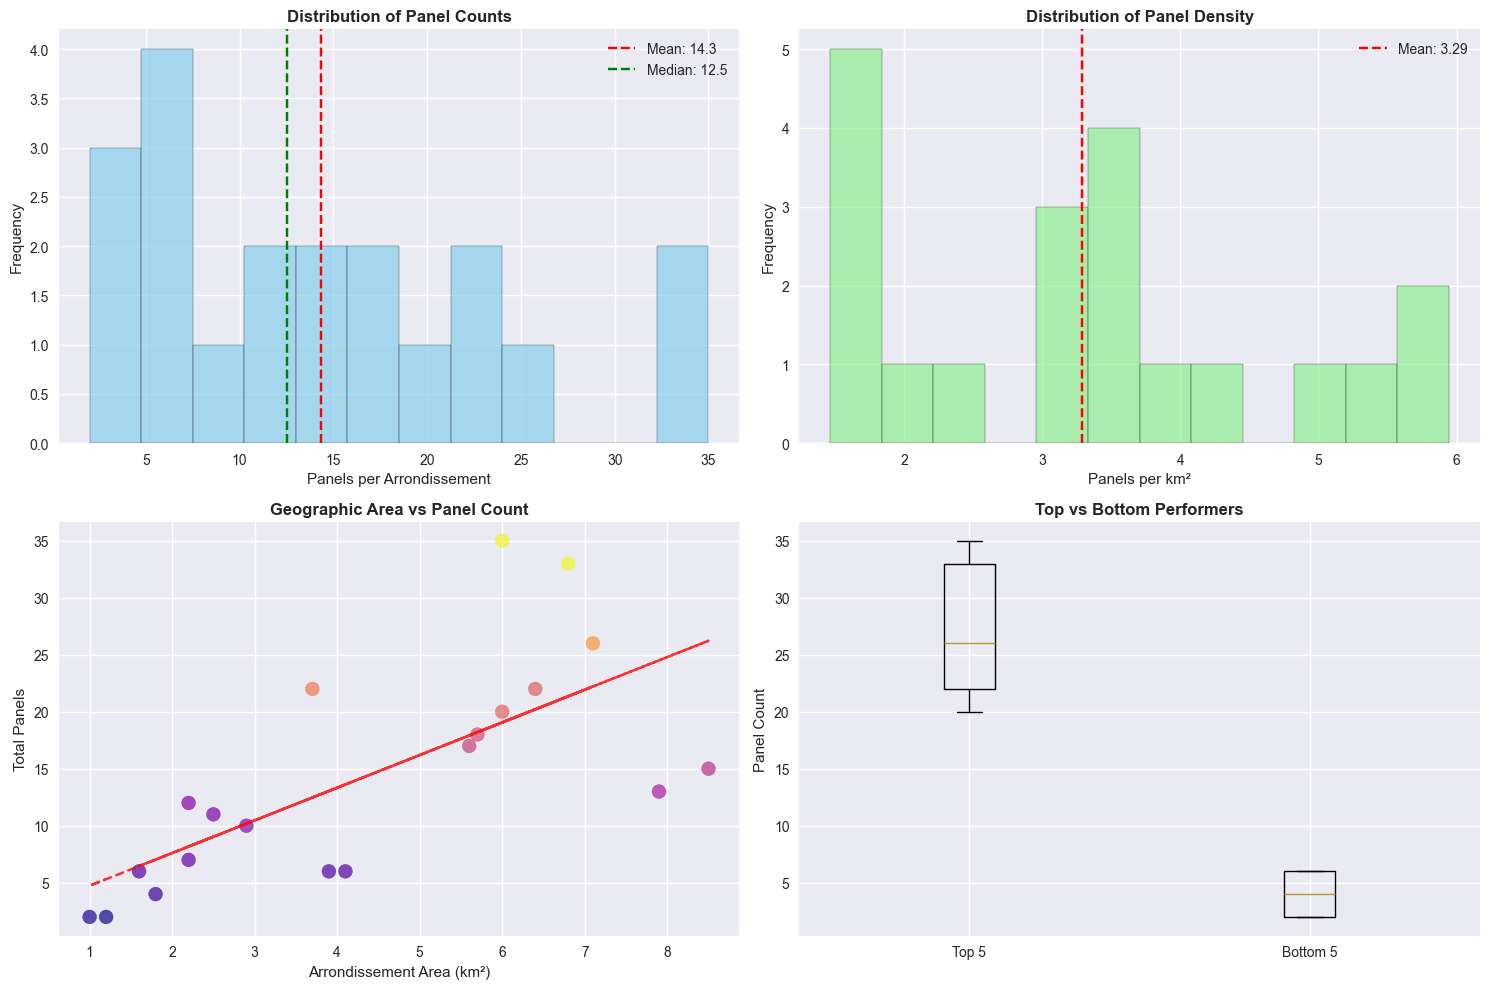

STATISTICAL SUMMARY
Panel count statistics:
  Mean: 14.3
  Median: 12.5
  Std Dev: 9.7
  Range: 2.0-35.0

Density statistics:
  Mean: 3.29 panels/km²
  Median: 3.26 panels/km²
  Range: 1.46-5.95


In [42]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Distribution of panel counts
axes[0,0].hist(panel_analysis['total_panels'], bins=12, alpha=0.7, color='skyblue', edgecolor='black')
axes[0,0].axvline(panel_analysis['total_panels'].mean(), color='red', linestyle='--', 
                 label=f'Mean: {panel_analysis["total_panels"].mean():.1f}')
axes[0,0].axvline(panel_analysis['total_panels'].median(), color='green', linestyle='--', 
                 label=f'Median: {panel_analysis["total_panels"].median():.1f}')
axes[0,0].set_title('Distribution of Panel Counts', fontweight='bold')
axes[0,0].set_xlabel('Panels per Arrondissement')
axes[0,0].set_ylabel('Frequency')
axes[0,0].legend()

# 2. Panel density distribution
axes[0,1].hist(panel_analysis['panel_density'], bins=12, alpha=0.7, color='lightgreen', edgecolor='black')
axes[0,1].axvline(panel_analysis['panel_density'].mean(), color='red', linestyle='--', 
                 label=f'Mean: {panel_analysis["panel_density"].mean():.2f}')
axes[0,1].set_title('Distribution of Panel Density', fontweight='bold')
axes[0,1].set_xlabel('Panels per km²')
axes[0,1].set_ylabel('Frequency')
axes[0,1].legend()

# 3. Area vs arrondissement size correlation
axes[1,0].scatter(panel_analysis['area_km2'], panel_analysis['total_panels'], 
                 s=100, alpha=0.7, c=panel_analysis['infrastructure_score'], cmap='plasma')
axes[1,0].set_title('Geographic Area vs Panel Count', fontweight='bold')
axes[1,0].set_xlabel('Arrondissement Area (km²)')
axes[1,0].set_ylabel('Total Panels')

# Add trendline
z = np.polyfit(panel_analysis['area_km2'], panel_analysis['total_panels'], 1)
p = np.poly1d(z)
axes[1,0].plot(panel_analysis['area_km2'], p(panel_analysis['area_km2']), "r--", alpha=0.8)

# 4. Top vs bottom performers comparison
top_5 = panel_analysis.head(5)['arrondissement_clean'].tolist()
bottom_5 = panel_analysis.tail(5)['arrondissement_clean'].tolist()

top_data = panel_analysis[panel_analysis['arrondissement_clean'].isin(top_5)]['total_panels']
bottom_data = panel_analysis[panel_analysis['arrondissement_clean'].isin(bottom_5)]['total_panels']

axes[1,1].boxplot([top_data, bottom_data], labels=['Top 5', 'Bottom 5'])
axes[1,1].set_title('Top vs Bottom Performers', fontweight='bold')
axes[1,1].set_ylabel('Panel Count')

plt.tight_layout()
plt.show()

# Print statistical summary
print("STATISTICAL SUMMARY")
print("=" * 30)
print(f"Panel count statistics:")
print(f"  Mean: {panel_analysis['total_panels'].mean():.1f}")
print(f"  Median: {panel_analysis['total_panels'].median():.1f}")
print(f"  Std Dev: {panel_analysis['total_panels'].std():.1f}")
print(f"  Range: {panel_analysis['total_panels'].min()}-{panel_analysis['total_panels'].max()}")

print(f"\nDensity statistics:")
print(f"  Mean: {panel_analysis['panel_density'].mean():.2f} panels/km²")
print(f"  Median: {panel_analysis['panel_density'].median():.2f} panels/km²")
print(f"  Range: {panel_analysis['panel_density'].min():.2f}-{panel_analysis['panel_density'].max():.2f}")

In [43]:
print("ASSOCIATIVE PANEL INFRASTRUCTURE INTELLIGENCE")
print("=" * 60)

print("KEY METRICS:")
print(f"  Total associative panels: {int(panels_valid['total_panels'].sum())}")
print(f"  Total civic panel area: {int(panels_valid['total_area'].sum())} m²")
print(f"  Geographic coverage: {len(panel_analysis)}/20 arrondissements (100%)")
print(f"  Average panels per arrondissement: {panels_valid['total_panels'].sum()/len(panel_analysis):.1f}")
print(f"  Coordinate precision: {len(valid_coords)/len(panels_valid)*100:.1f}%")

print(f"\nCIVIC INFRASTRUCTURE LEADERS:")
for i, (_, row) in enumerate(panel_analysis.head(5).iterrows(), 1):
    print(f"  {i}. Arr. {row['arrondissement_clean']}: {row['total_panels']:.0f} panels, {row['total_area']:.0f} m², {row['panel_density']:.2f}/km²")

print(f"\nFORMAT STRATEGY:")
total_1m2 = int(panels_valid['format_1m2'].sum())
total_2m2 = int(panels_valid['format_2m2'].sum())
print(f"  Large panel focus: {total_2m2} × 2m² panels ({total_2m2/(total_1m2+total_2m2)*100:.1f}%)")
print(f"  Small panel complement: {total_1m2} × 1m² panels ({total_1m2/(total_1m2+total_2m2)*100:.1f}%)")
print(f"  Civic approach: Quality over quantity")

print(f"\nMARKETING INTELLIGENCE INSIGHTS:")
high_density = panel_analysis[panel_analysis['panel_density'] > panel_analysis['panel_density'].mean()]
print(f"  High civic density areas: {len(high_density)} arrondissements")
print(f"  Established infrastructure zones: {', '.join(high_density['arrondissement_clean'].tolist())}")
print(f"  Density range: {panel_analysis['panel_density'].min():.2f} - {panel_analysis['panel_density'].max():.2f} panels/km²")

print(f"\nCOMMERCIAL PLACEMENT STRATEGY:")
efficient_areas = panel_analysis[panel_analysis['infrastructure_score'] > panel_analysis['infrastructure_score'].mean()]
print(f"  Areas with proven civic engagement: {len(efficient_areas)} arrondissements")
print(f"  Top civic infrastructure zones: {', '.join(efficient_areas.head(3)['arrondissement_clean'].tolist())}")
print(f"  Commercial opportunity: Use civic patterns to inform advertising placement")

print(f"\nREADY FOR MARKETING CORRELATION:")
print(f"  Clean civic dataset: 287 validated records")
print(f"  Complete geographic coverage for marketing analysis")
print(f"  Civic infrastructure patterns ready for commercial placement strategy")

ASSOCIATIVE PANEL INFRASTRUCTURE INTELLIGENCE
KEY METRICS:
  Total associative panels: 287
  Total civic panel area: 533 m²
  Geographic coverage: 20/20 arrondissements (100%)
  Average panels per arrondissement: 14.3
  Coordinate precision: 99.3%

CIVIC INFRASTRUCTURE LEADERS:
  1. Arr. 19: 33 panels, 66 m², 4.85/km²
  2. Arr. 20: 35 panels, 61 m², 5.83/km²
  3. Arr. 13: 26 panels, 49 m², 3.66/km²
  4. Arr. 11: 22 panels, 44 m², 5.95/km²
  5. Arr. 18: 20 panels, 40 m², 3.33/km²

FORMAT STRATEGY:
  Large panel focus: 246 × 2m² panels (85.7%)
  Small panel complement: 41 × 1m² panels (14.3%)
  Civic approach: Quality over quantity

MARKETING INTELLIGENCE INSIGHTS:
  High civic density areas: 10 arrondissements
  Established infrastructure zones: 19, 20, 13, 11, 18, 12, 10, 6, 5, 4
  Density range: 1.46 - 5.95 panels/km²

COMMERCIAL PLACEMENT STRATEGY:
  Areas with proven civic engagement: 9 arrondissements
  Top civic infrastructure zones: 19, 20, 13
  Commercial opportunity: Use civic 

In [44]:
# Export processed datasets
panels_valid.to_csv('../data/processed/panels_processed.csv', index=False)
panel_analysis.to_csv('../data/processed/panel_infrastructure_analysis.csv', index=False)
valid_coords.to_csv('../data/processed/panel_locations_with_coordinates.csv', index=False)

panel_summary = {
    'dataset_info': {
        'total_records': len(panels_valid),
        'coordinate_coverage': len(valid_coords),
        'arrondissements_covered': len(panel_analysis),
        'data_quality_score': len(valid_coords)/len(panels_valid)*100
    },
    'civic_infrastructure_metrics': {
        'total_associative_panels': int(panels_valid['total_panels'].sum()),
        'total_area_m2': int(panels_valid['total_area'].sum()),
        'format_1m2_count': int(panels_valid['format_1m2'].sum()),
        'format_2m2_count': int(panels_valid['format_2m2'].sum()),
        'avg_panels_per_arrondissement': float(panels_valid['total_panels'].sum()/len(panel_analysis))
    },
    'marketing_intelligence': {
        'civic_infrastructure_leaders': panel_analysis.head(5)[['arrondissement_clean', 'total_panels', 'infrastructure_score']].to_dict('records'),
        'high_density_areas': panel_analysis.nlargest(5, 'panel_density')[['arrondissement_clean', 'panel_density']].to_dict('records'),
        'commercial_placement_insights': 'Areas with high civic engagement may indicate good commercial potential'
    }
}

with open('../data/summaries/associative_panels_summary.json', 'w') as f:
    json.dump(panel_summary, f, indent=2, default=str)

print("\npanels analysis complete!")


panels analysis complete!
